## Baseline CNN model with MFCC

## 1. Setup and Imports


In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed for reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

print(f"TensorFlow version: {tf.__version__}")


TensorFlow version: 2.20.0


## 2. Download and Explore the Dataset

We'll use a subset of the Speech Commands dataset containing 8 commands plus background noise.


In [2]:
# Path to the mini speech commands dataset
DATASET_PATH = 'data/mini_speech_commands_extracted/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    # Download if not present
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir='.', cache_subdir='data'
    )
    
print(f"Dataset location: {data_dir}")


Dataset location: data\mini_speech_commands_extracted\mini_speech_commands


## 3. Create Training, Validation, and Test Datasets


In [3]:
# Audio parameters
BATCH_SIZE = 64
SAMPLE_RATE = 16000  # 16 kHz
AUDIO_LENGTH = 16000  # 1 second of audio

# Create training dataset (80% of data)
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    seed=SEED,
    output_sequence_length=AUDIO_LENGTH,
    subset='both'
)

# Get label names
label_names = np.array(train_ds.class_names)
print(f"Label names: {label_names}")


Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.
Label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [4]:
# The audio is loaded as (batch, samples, channels)
# We need to squeeze to remove the channel dimension for mono audio
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)


In [5]:
# Split validation set into validation and test sets
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

# Check the shapes
for example_audio, example_labels in train_ds.take(1):
    print(f"Audio shape: {example_audio.shape}")
    print(f"Labels shape: {example_labels.shape}")


Audio shape: (64, 16000)
Labels shape: (64,)


## 5. Convert Audio to Spectrograms

CNNs work well with image-like inputs. We convert audio waveforms to spectrograms, which represent frequency content over time.


In [12]:
def get_spectrogram(waveform):
    """
    Convert waveform to spectrogram using Mel-Frequency Cepstral Coefficients (MFCC).
    
    Parameters:
    - waveform: Audio signal tensor
    
    Returns:
    - Spectrogram tensor
    """
    # Compute STFT
    spectrogram = tf.signal.stft(
        waveform, 
        frame_length=255,  # Window size
        frame_step=128     # Hop length
    )
    
    # Get magnitude (discard phase information)
    spectrograms = tf.abs(spectrogram)
    
    # Warp the linear scale spectrograms into the mel-scale.
    num_spectrogram_bins = spectrogram.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 80
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins, num_spectrogram_bins, SAMPLE_RATE, lower_edge_hertz,
    upper_edge_hertz)
    mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
    linear_to_mel_weight_matrix.shape[-1:]))

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    # Compute MFCCs from log_mel_spectrograms and take the first 13.
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :13]
    # Add channel dimension for Conv2D
    mfccs = mfccs[..., tf.newaxis]
    
    return mfccs


In [13]:

# Test the spectrogram function
for i, (audio, label) in enumerate(train_ds.take(1)):
    example_audio = audio[0]
    example_label = label[0]
    
spectrogram = get_spectrogram(example_audio)
print(f"Waveform shape: {example_audio.shape}")
print(f"Spectrogram shape: {spectrogram.shape}")
print(f"Label: {label_names[example_label]}")


Waveform shape: (16000,)
Spectrogram shape: (124, 13, 1)
Label: stop


C:\Users\cliff\AppData\Local\Temp\ipykernel_16516\3855141053.py:13: RuntimeWarning: invalid value encountered in log
  log_spec = np.log(spectrogram.numpy()[:, :, 0].T + np.finfo(float).eps)


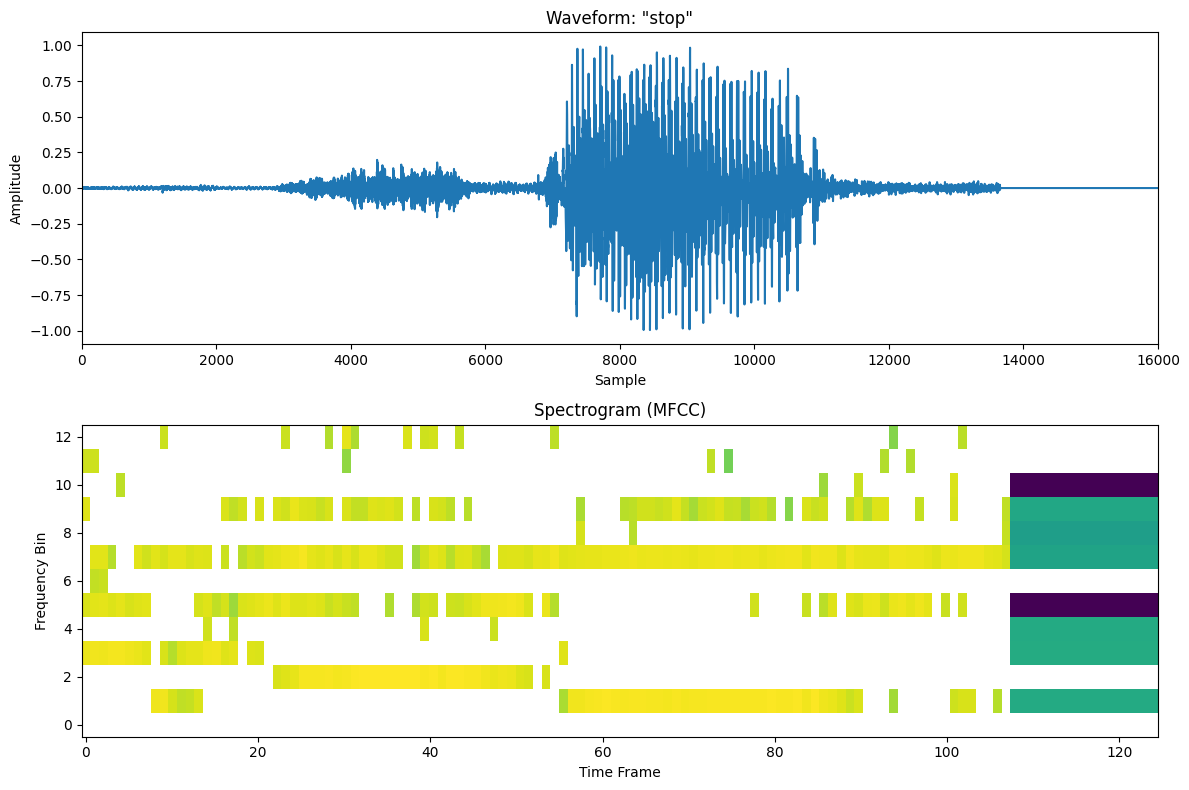

In [14]:
# Visualize the waveform and spectrogram
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot waveform
timescale = np.arange(example_audio.shape[0])
axes[0].plot(timescale, example_audio.numpy())
axes[0].set_title(f'Waveform: "{label_names[example_label]}"')
axes[0].set_xlabel('Sample')
axes[0].set_ylabel('Amplitude')
axes[0].set_xlim([0, AUDIO_LENGTH])

# Plot spectrogram
log_spec = np.log(spectrogram.numpy()[:, :, 0].T + np.finfo(float).eps)
height = log_spec.shape[0]
width = log_spec.shape[1]
X = np.linspace(0, width, num=width)
Y = range(height)
axes[1].pcolormesh(X, Y, log_spec, shading='auto', cmap='viridis')
axes[1].set_title('Spectrogram (MFCC)')
axes[1].set_xlabel('Time Frame')
axes[1].set_ylabel('Frequency Bin')

plt.tight_layout()
plt.savefig('figures/spectrogram_example.png', dpi=150, bbox_inches='tight')
plt.show()


In [15]:
# Create spectrogram dataset
def make_spec_ds(ds):
    """Convert audio dataset to spectrogram dataset."""
    return ds.map(
        lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)


In [16]:
# Check spectrogram dataset shapes
for example_spectrograms, example_labels in train_spectrogram_ds.take(1):
    print(f"Spectrogram batch shape: {example_spectrograms.shape}")
    print(f"Labels batch shape: {example_labels.shape}")
    break


Spectrogram batch shape: (64, 124, 13, 1)
Labels batch shape: (64,)


C:\Users\cliff\AppData\Local\Temp\ipykernel_16516\3112548541.py:6: RuntimeWarning: invalid value encountered in log
  log_spec = np.log(spectrogram[0].numpy()[:, :, 0].T + np.finfo(float).eps)


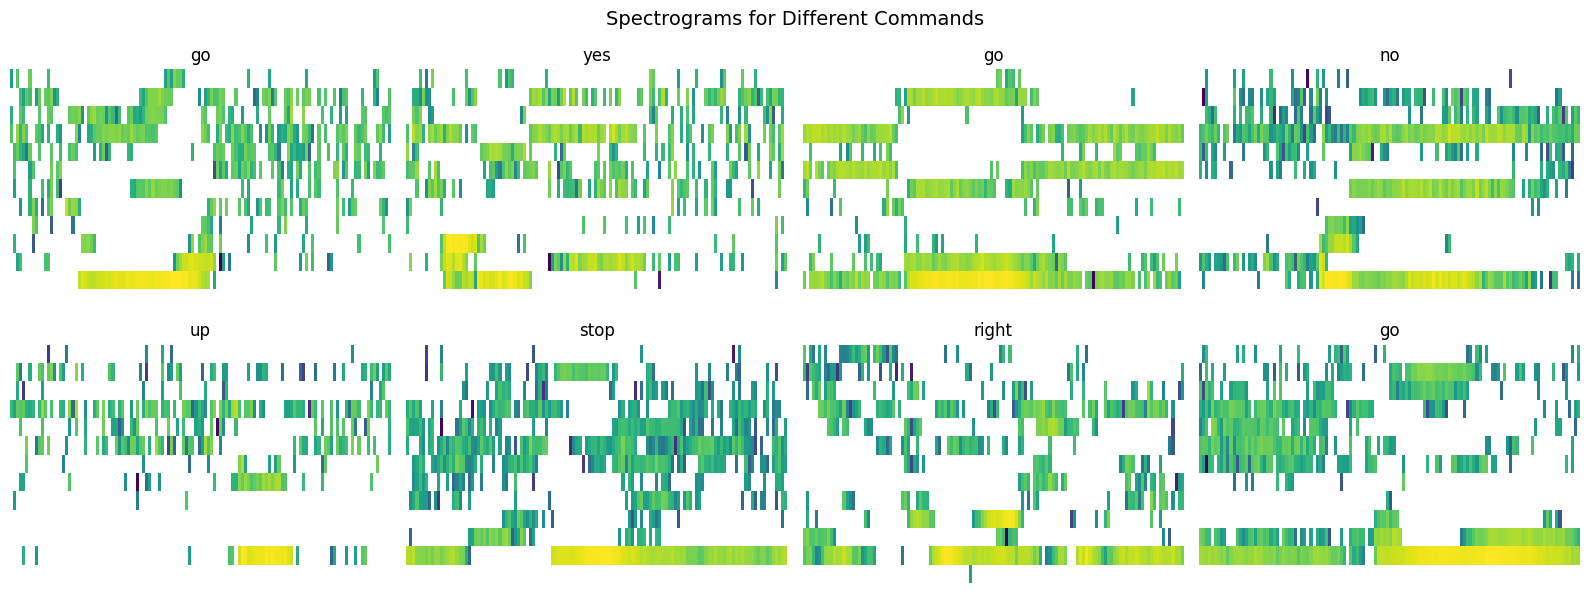

In [17]:
# Visualize spectrograms for each command
fig, axes = plt.subplots(2, 4, figsize=(16, 6))

for i, (spectrogram, label_id) in enumerate(train_spectrogram_ds.take(8)):
    ax = axes[i // 4, i % 4]
    log_spec = np.log(spectrogram[0].numpy()[:, :, 0].T + np.finfo(float).eps)
    ax.pcolormesh(log_spec, shading='auto', cmap='viridis')
    ax.set_title(label_names[label_id[0].numpy()])
    ax.axis('off')

plt.suptitle('Spectrograms for Different Commands', fontsize=14)
plt.tight_layout()
plt.savefig('figures/spectrograms_by_command.png', dpi=150, bbox_inches='tight')
plt.show()


## 6. Optimize Dataset Performance


In [18]:
# Cache and prefetch for better performance
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)


## 7. Build the CNN Model

We build a simple CNN architecture for audio classification.


In [19]:
# Get input shape from dataset
for example_spectrograms, _ in train_spectrogram_ds.take(1):
    input_shape = example_spectrograms.shape[1:]
    
print(f"Input shape: {input_shape}")
num_labels = len(label_names)
print(f"Number of labels: {num_labels}")


Input shape: (124, 13, 1)
Number of labels: 8


In [20]:
# Normalization layer
norm_layer = layers.Normalization()

# Adapt normalization layer to training data
norm_layer.adapt(data=train_spectrogram_ds.map(lambda spec, label: spec))


In [21]:
# Build the CNN model
model = models.Sequential([
    layers.Input(shape=input_shape),
    
    # Normalize input
    norm_layer,
    
    # First convolutional block
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    # Flatten and classify
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 124, 13, 1)     │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 122, 11, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 120, 9, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 60, 4, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 4, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,966,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,986,059 (7.58 MB)

 Trainable params: 1,986,056 (7.58 MB)

 Non-trainable params: 3 (16.00 B)

In [22]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


## 8. Train the Model


In [23]:
# Create models directory
os.makedirs('models', exist_ok=True)

# Training parameters
EPOCHS = 10

# Train the model
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.3512 - loss: 1.7145 - val_accuracy: 0.5846 - val_loss: 1.2265
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5747 - loss: 1.1944 - val_accuracy: 0.6576 - val_loss: 0.9698
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6363 - loss: 1.0286 - val_accuracy: 0.6966 - val_loss: 0.8882
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6727 - loss: 0.9090 - val_accuracy: 0.7266 - val_loss: 0.8161
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7058 - loss: 0.8253 - val_accuracy: 0.7266 - val_loss: 0.7723
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7248 - loss: 0.7583 - val_accuracy: 0.7422 - val_loss: 0.7195
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7447 - loss: 0.7112 - val_accuracy: 0.7487 - val_loss: 0.7147
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7531 - loss: 0.6671 - val_accu

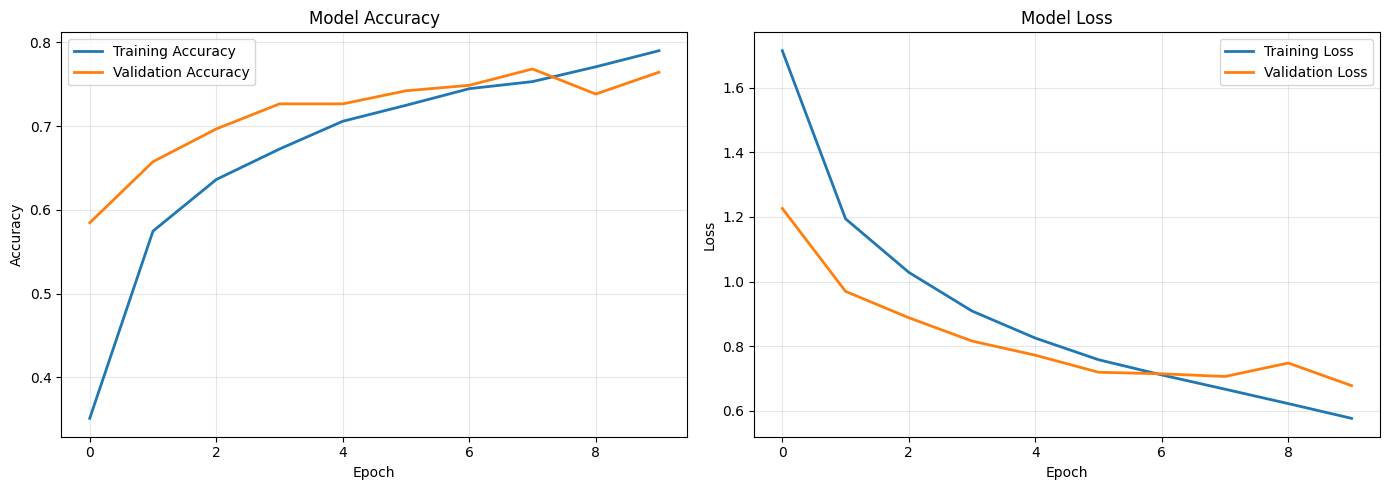

In [24]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/training_history.png', dpi=150, bbox_inches='tight')
plt.show()


## 9. Evaluate the Model


In [25]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_spectrogram_ds)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7993 - loss: 0.6459

Test Accuracy: 0.7993
Test Loss: 0.6459


In [26]:
# Generate predictions for confusion matrix
y_pred = []
y_true = []

for spectrograms, labels in test_spectrogram_ds:
    predictions = model.predict(spectrograms, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)


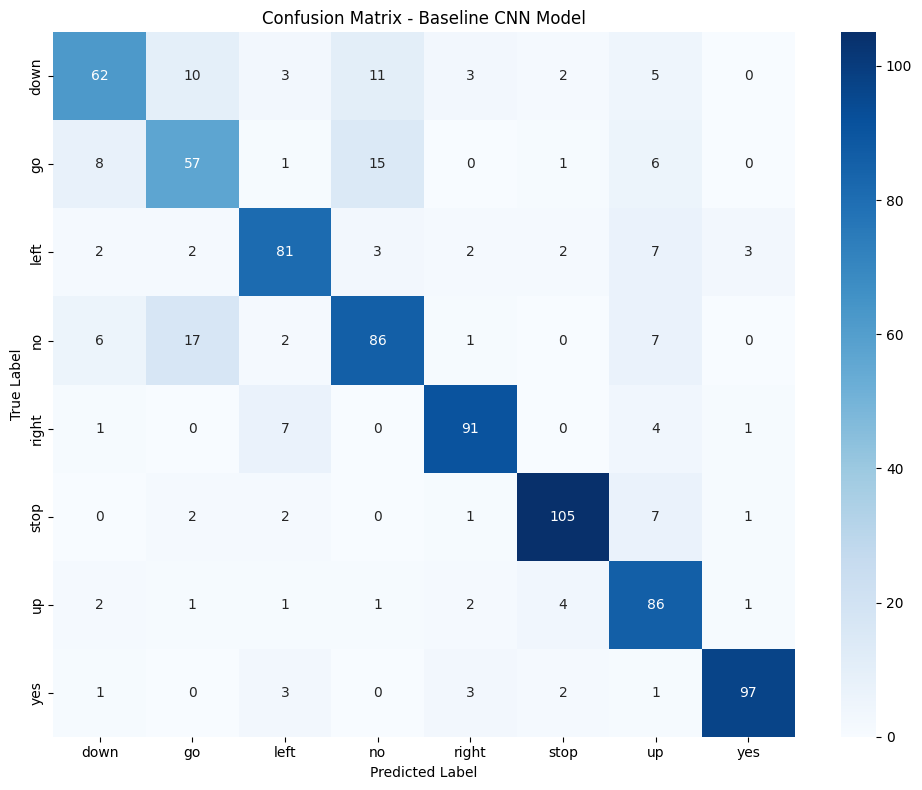

In [27]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Baseline CNN Model')
plt.tight_layout()
plt.savefig('figures/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()


In [28]:
# Print classification report
print("\nClassification Report:")
print("=" * 60)
print(classification_report(y_true, y_pred, target_names=label_names))



Classification Report:
              precision    recall  f1-score   support

        down       0.76      0.65      0.70        96
          go       0.64      0.65      0.64        88
        left       0.81      0.79      0.80       102
          no       0.74      0.72      0.73       119
       right       0.88      0.88      0.88       104
        stop       0.91      0.89      0.90       118
          up       0.70      0.88      0.78        98
         yes       0.94      0.91      0.92       107

    accuracy                           0.80       832
   macro avg       0.80      0.79      0.79       832
weighted avg       0.80      0.80      0.80       832



## 11. Save the Model


In [29]:
# Save the model
model.save('models/mfcc_baseline_cnn_model.keras')
print("Model saved to 'models/mfcc_baseline_cnn_model.keras'")


Model saved to 'models/mfcc_baseline_cnn_model.keras'


In [31]:
# Save results summary
results = {
    'model_name': 'Baseline CNN + MFCC',
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'num_epochs': len(history.history['loss']),
    'final_train_accuracy': history.history['accuracy'][-1],
    'final_val_accuracy': history.history['val_accuracy'][-1],
    'input_type': 'Spectrogram (STFT + MFCC)',
    'num_parameters': model.count_params(),
}

print("\n" + "=" * 50)
print("BASELINE WITH MFCC CNN MODEL RESULTS")
print("=" * 50)
for key, value in results.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")



BASELINE WITH MFCC CNN MODEL RESULTS
model_name: Baseline CNN + MFCC
test_accuracy: 0.7993
test_loss: 0.6459
num_epochs: 10
final_train_accuracy: 0.7900
final_val_accuracy: 0.7643
input_type: Spectrogram (STFT + MFCC)
num_parameters: 1986059


## 12. Summary

### Results Summary
This notebook modified baseline cnn model by applying mfcc after stft, which extract the audio features.

- reduce the parameter of cnn from around 30M to 2M
- accuracy only drops around 2%



# Reference
https://www.tensorflow.org/api_docs/python/tf/signal/mfccs_from_log_mel_spectrograms